In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math

configuration = tflscripts.read_configuration()

In [15]:
datasets_and_devices = [
    ['synergy-final-iter1', '128.237.254.195'],
    ['synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134'],
    ['scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127'],
    ['robotics-final', '128.237.247.134']
]

null_df = []
complete_df = []
for dataset, device in datasets_and_devices:
    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')

    complete_df.append(df)
    null_df.append(df.loc[df.label == configuration['activities'].index('Null')])

null_df = pd.concat(null_df)
null_df = null_df.reset_index()

complete_df = pd.concat(complete_df)
complete_df = complete_df.reset_index()

In [3]:

# df_labels = pd.read_pickle(dataset_path + device + '_labels.p')
# df['label'] = df_labels['label']

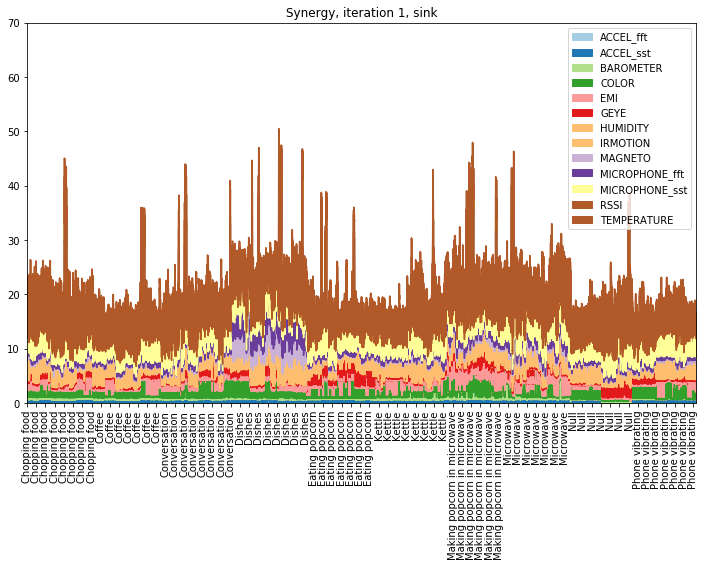

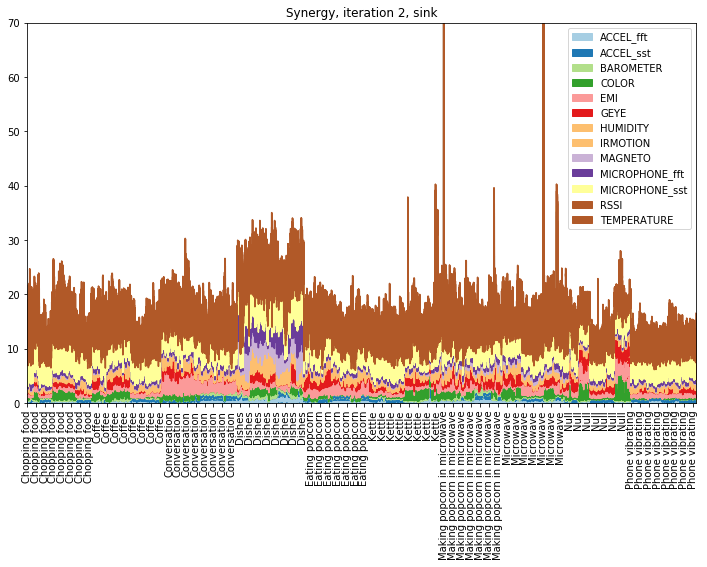

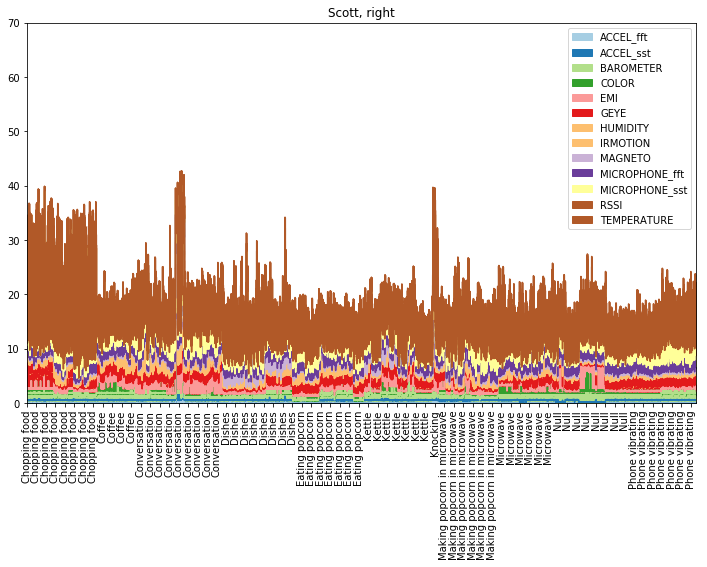

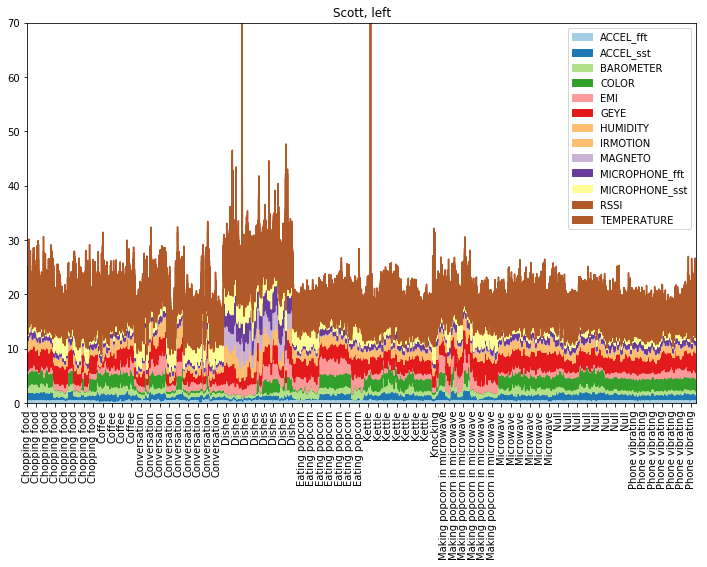

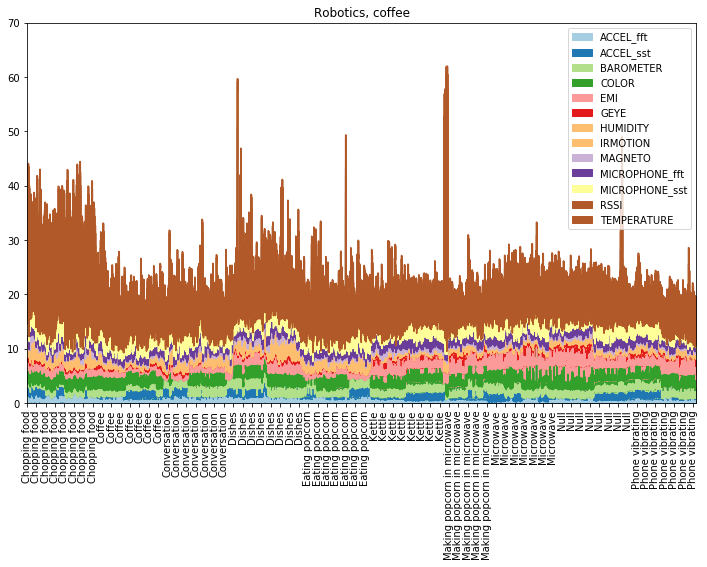

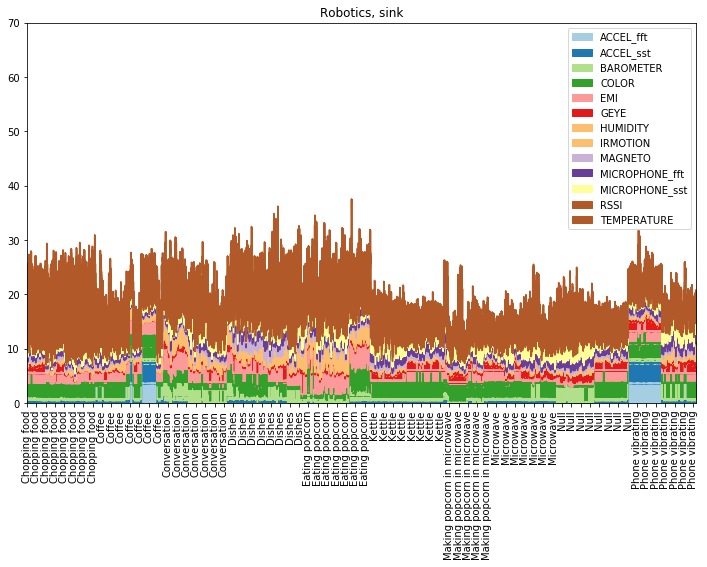

In [17]:
sensor_channels = [
    'MICROPHONE_fft',
    'MICROPHONE_sst',
    'ACCEL_fft',
    'ACCEL_sst',
    'EMI',
    'MAGNETO',
    'GEYE',
    'COLOR',
    'TEMPERATURE',
    'IRMOTION',
    'RSSI',
    'HUMIDITY',
    'BAROMETER'
]
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Making popcorn in microwave",
    "Knocking",
    "Phone vibrating"
]

tests = [
    ['synergy-final-iter1', '128.237.254.195'],
    ['synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134'],
    ['scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127'],
    ['robotics-final', '128.237.247.134'],
]

test_labels = [
    'Synergy, iteration 1, sink',
    'Synergy, iteration 2, sink',
    'Scott, right',
    'Scott, left',
    'Robotics, coffee',
    'Robotics, sink',
]

for k, test in enumerate(tests):
    dataset_path = '../datasets/' + test[0] + '-complete/'
    df = pd.read_pickle(dataset_path + test[1] + '.p')

    channel_anomalies = {}

    for channel in sensor_channels:
        value_columns = df.filter(regex=channel).columns

        mean = complete_df[value_columns].mean()
        std = complete_df[value_columns].std()
        df[value_columns] = df[value_columns].clip(mean - 2 * std, mean + 2 * std, axis=1)

#         null_df = df.loc[df.label == configuration['activities'].index('Null')]
        null_mean = null_df[value_columns].mean()
        null_std = null_df[value_columns].std()

        anomalies = (((df[value_columns] - null_mean) / null_std) ** 2).sum(axis=1).apply(np.sqrt)
        channel_anomalies[channel] = anomalies

    anomalies = pd.DataFrame(channel_anomalies)
    anomalies['label'] = [configuration['activities'][int(i)] for i in df.label]
    anomalies = anomalies.sort_values(['label'])
    anomalies = anomalies.loc[anomalies.label.isin(activities)]
    anomalies = anomalies.reset_index()

    anomaly_columns = anomalies.filter(regex='|'.join(sensor_channels)).columns
#     anomalies[anomaly_columns] = anomalies[anomaly_columns].clip(upper=300.0, axis=1)
    anomalies[anomaly_columns] = StandardScaler().fit_transform(anomalies[anomaly_columns])
    anomalies[anomaly_columns] = anomalies[anomaly_columns] - anomalies[anomaly_columns].min()

    labels = anomalies.label.unique().tolist()
    anomalies['label_'] = [200 if labels.index(l) % 2 == 0 else 0 for l in anomalies['label']]

    anomalies.filter(regex='|'.join(sensor_channels)).plot.area(colormap='Paired')
    labels = anomalies.label
    plt.xticks(np.arange(0.5, len(labels), 500), labels[::500], rotation='vertical')
    plt.title(test_labels[k])
    plt.ylim([0, 70])
    plt.show()

In [66]:
for anomaly_type in anomalies:
    reshaped_values = {}
    max_length = 0
    for label in anomalies.label.unique():
        values = anomalies.loc[anomalies.label == label][anomaly_type].values
        complete = np.zeros(max_length)
        complete = np.concatenate([complete, values])

        reshaped_values[label] = complete
        max_length += len(values)

    for label in reshaped_values:
        values = reshaped_values[label]
        arr = np.zeros(max_length)
        arr[:len(values)] = values
        reshaped_values[label] = arr

    pd.DataFrame(reshaped_values).plot()
    plt.title(anomaly_type)

KeyError: 'accelerometer'

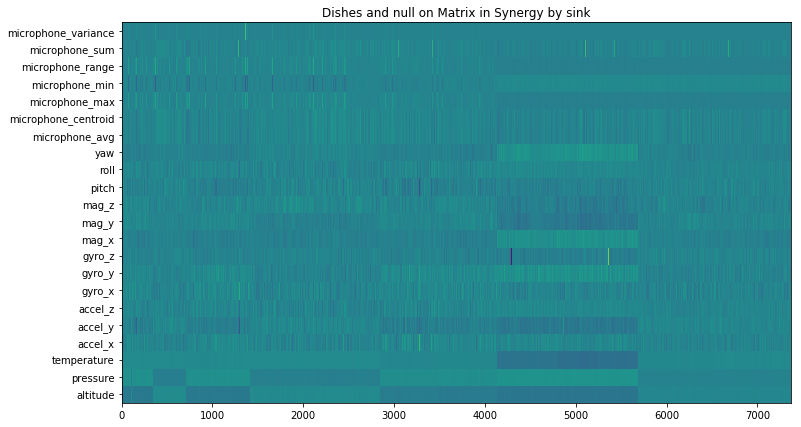

In [8]:
activities = [
    "Dishes",
    "Null"
]
activities_i = [configuration['activities'].index(a) for a in activities]

dataset_path = '../datasets/synergy-final-iter1-complete/'
df = pd.read_pickle(dataset_path + 'Matrix b827eb41f96f.p')
columns = df.filter(regex='^(?!label)').columns
df[columns] = StandardScaler().fit_transform(df[columns])

df = df.loc[df.label.isin(activities_i)]
df = df.sort_values(['label'])
# null_dfs.append(null_df)

df = df[columns]
df = df.T
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.title('Dishes and null on Matrix in Synergy by sink')

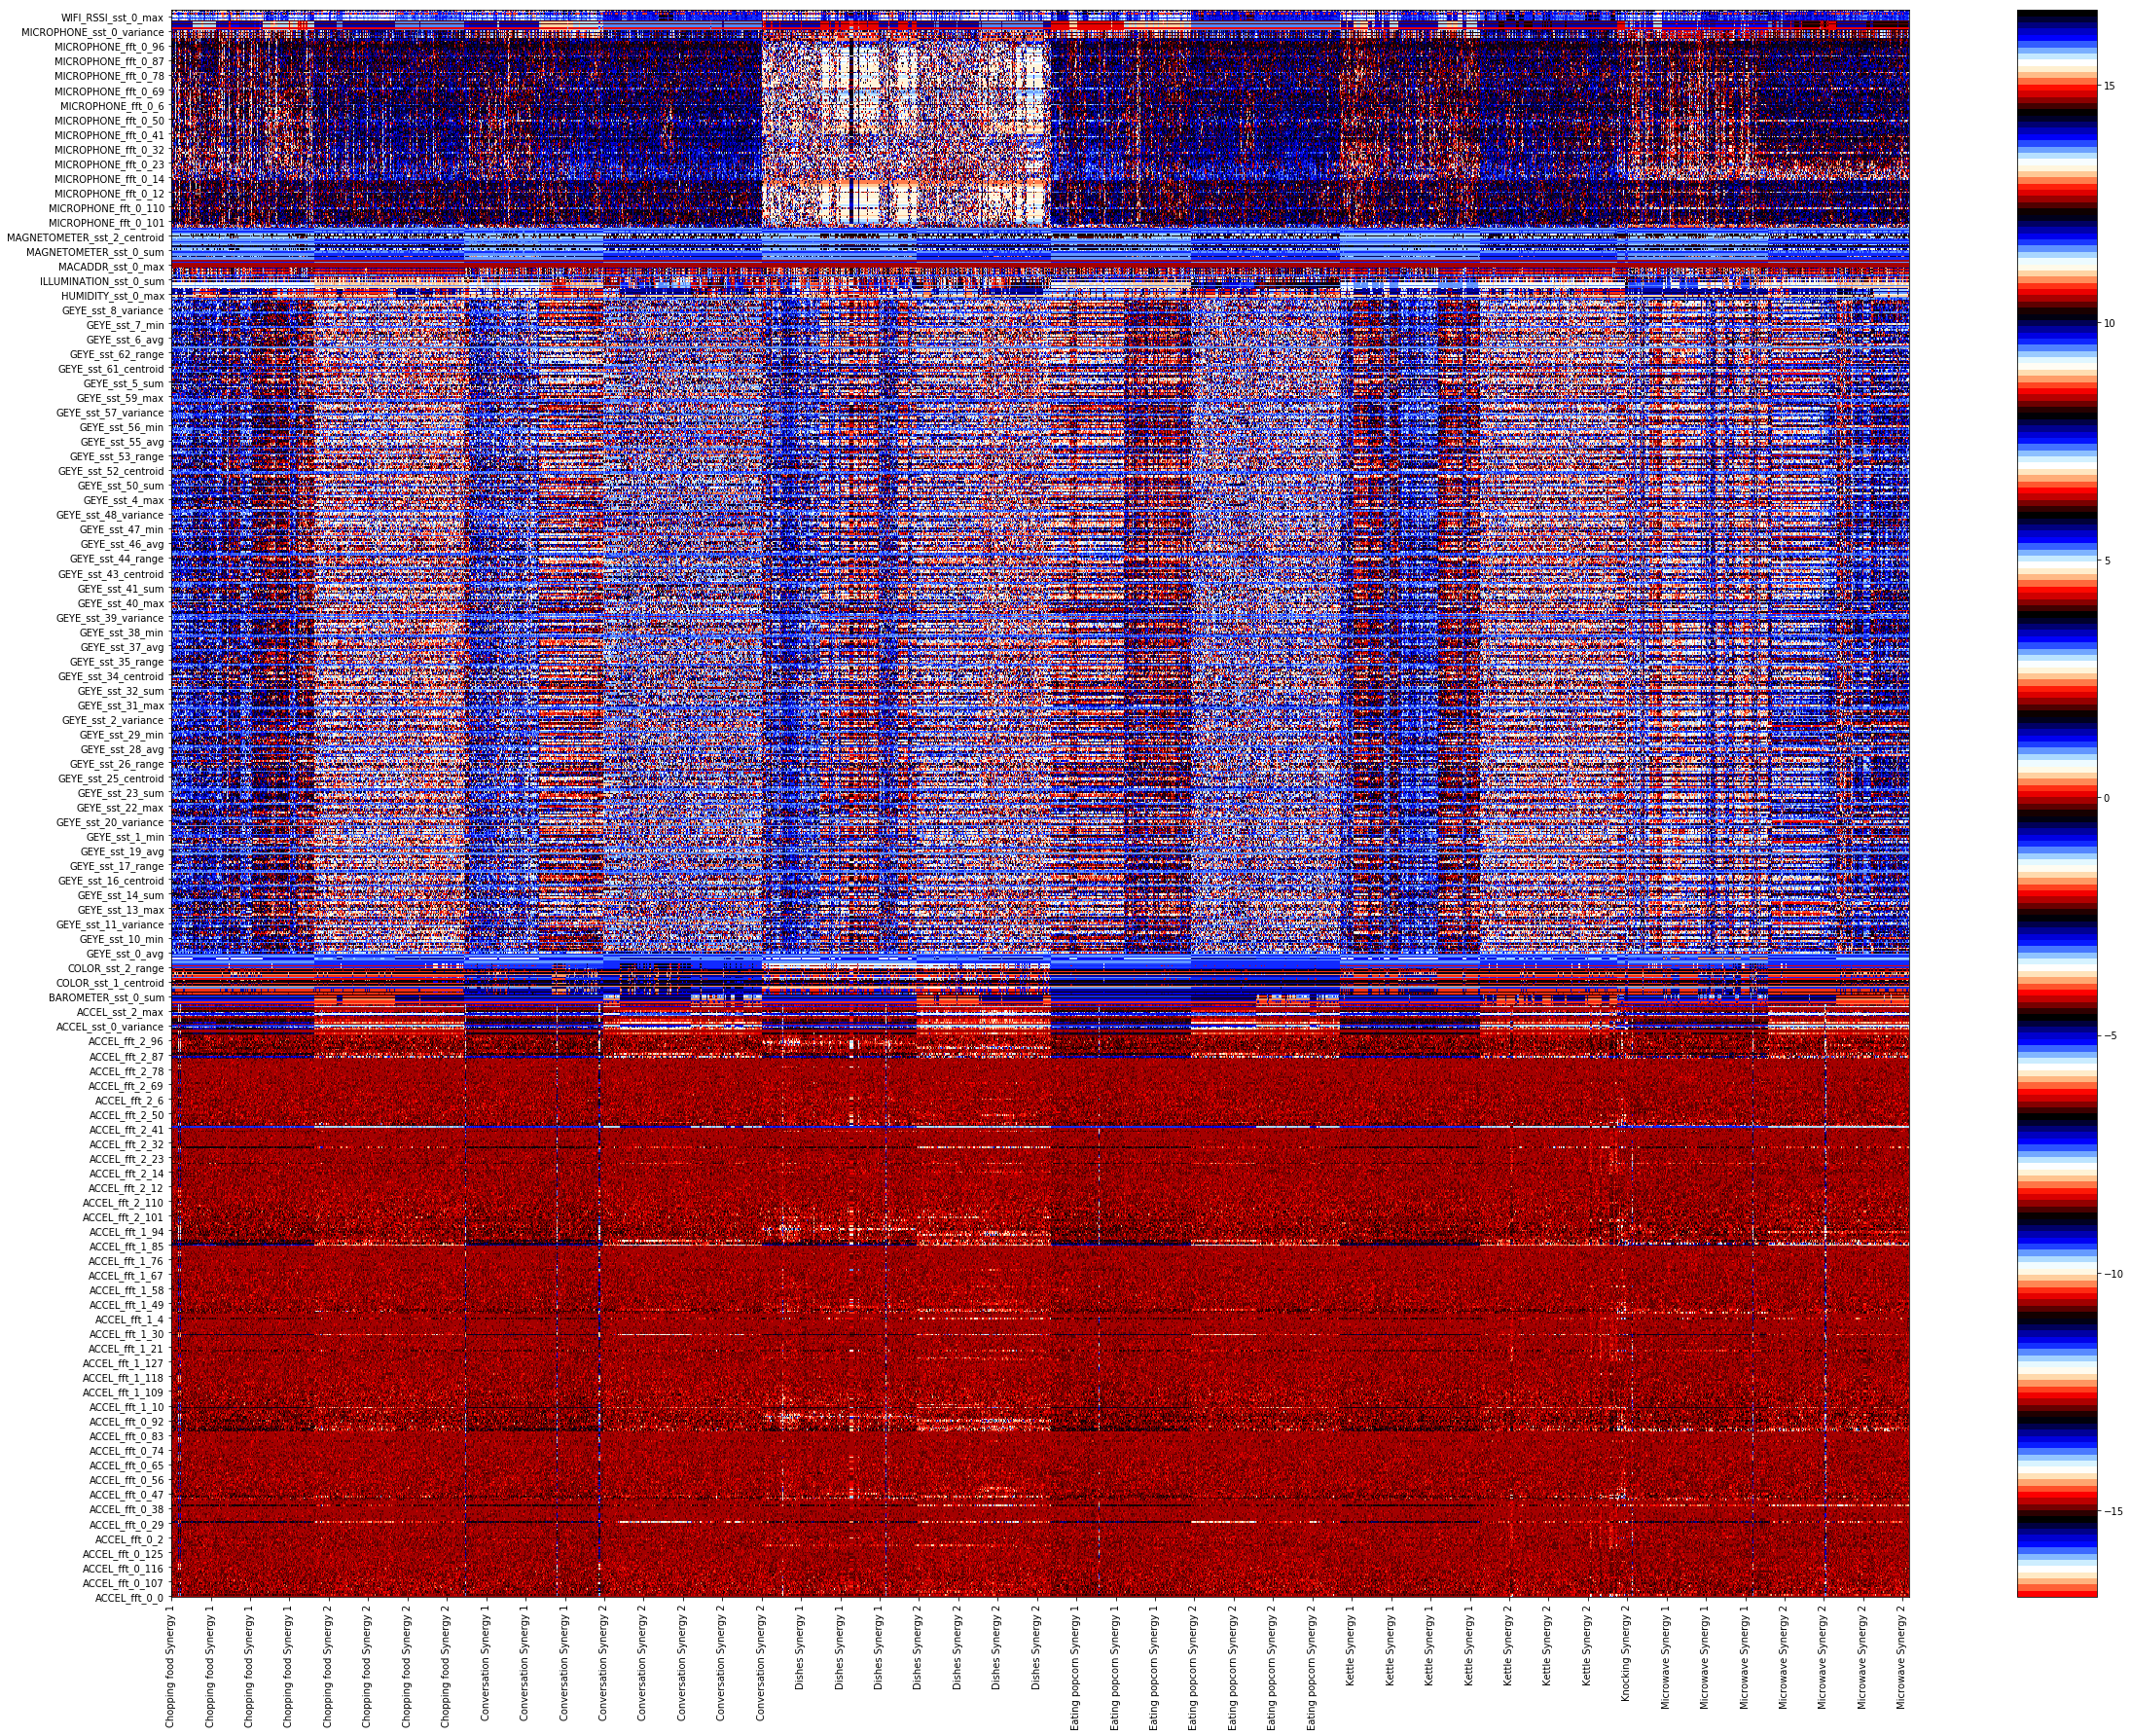

In [23]:
def read_dataset(dataset, device, activities):
    activities_i = [configuration['activities'].index(a) for a in activities]

    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')
    columns = df.filter(regex='^(?!label)').columns

    mean = complete_df[columns].mean()
    std = complete_df[columns].std()
    df[columns] = df[columns].clip(mean - 2 * std, mean + 2 * std, axis=1)

#     null_df = df.loc[df.label == configuration['activities'].index('Null')]
#     null_mean = null_df[columns].mean()
#     null_std = null_df[columns].std()

    df[columns] = (df[columns] - mean) / std
    df = df.replace([np.inf, -np.inf, np.nan], 0)
#     df[columns] = StandardScaler().fit_transform(df[columns])

    df = df.loc[df.label.isin(activities_i)]
    df = df.sort_values(['label'])

    split = np.random.rand(len(df)) < 0.1
    df = df[split]

    labels = df.label.values

    df = df[columns]

    return df, labels

plt.rcParams["figure.figsize"] = (40, 30)

activities = [
    "Dishes",
    "Microwave",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking"
]

df_1, labels_1 = read_dataset('synergy-final-iter1', '128.237.254.195', activities)
df_2, labels_2 = read_dataset('synergy-final-iter2', '128.237.248.186', activities)
# df_3, labels_3 = read_dataset('scott-final-iter1', '128.237.247.134', activities)

df = pd.concat([df_1, df_2])
# labels_1 = ['Synergy 1 ' + configuration['activities'][int(label)] for label in labels_1]
labels_1 = [configuration['activities'][int(label)] + ' Synergy 1' for label in labels_1]
labels_2 = [configuration['activities'][int(label)] + ' Synergy 2' for label in labels_2]
labels = np.concatenate([labels_1, labels_2])

df['label'] = labels
df = df.sort_values(['label'])
labels = df.label.values
df = df.filter(regex='^(?!label)')
df[df.columns] = StandardScaler().fit_transform(df[df.columns])

df = df.T

plt.pcolormesh(df, cmap='flag')
plt.xticks(np.arange(0.5, len(labels), 100), labels[::100], rotation='vertical')
plt.yticks(np.arange(0.5, len(df.index), 10), df.index[::10])
# plt.title('Mites in different spaces')
plt.colorbar()
plt.savefig('plots/heatmap_fft_data.png')

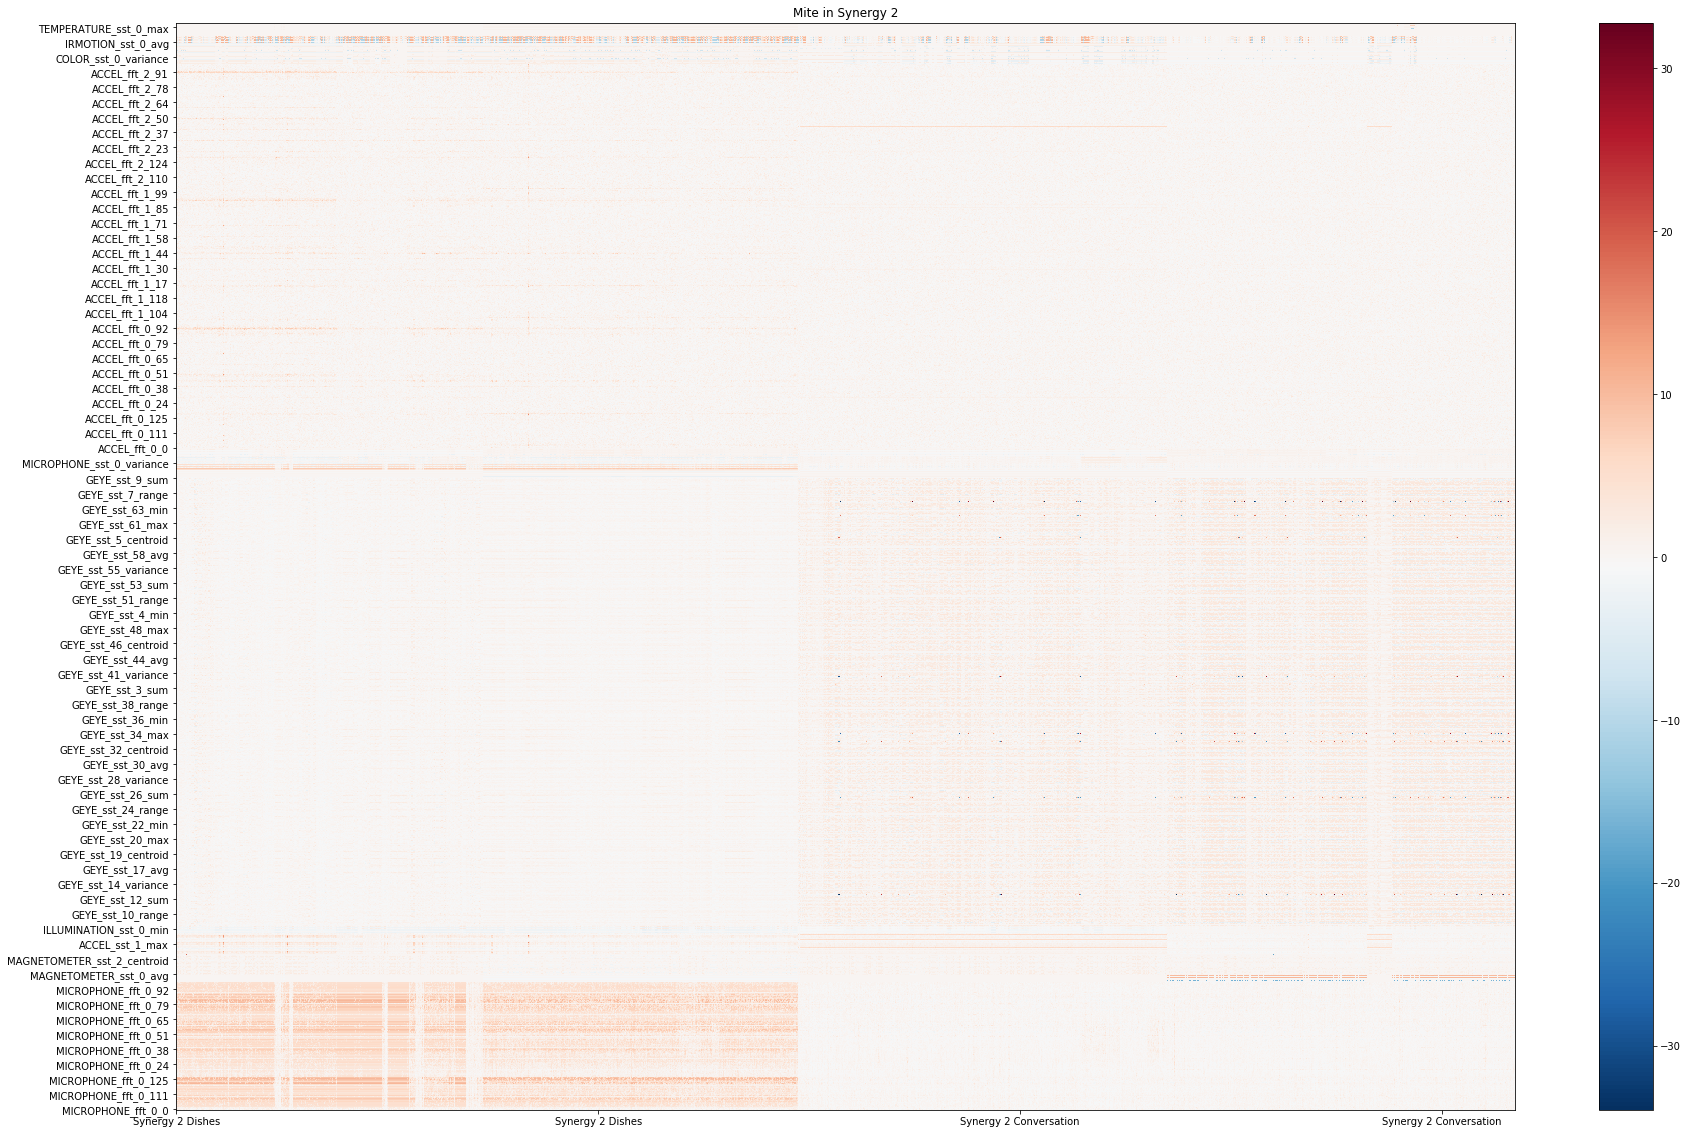

In [59]:
def read_dataset(dataset, device, activities):
    activities_i = [configuration['activities'].index(a) for a in activities]

    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')
    columns = df.filter(regex='^(?!label)').columns

    mean = df[columns].mean()
    std = df[columns].std()
    df[columns] = df[columns].clip(mean - 2 * std, mean + 2 * std, axis=1)

    null_df = df.loc[df.label == configuration['activities'].index('Null')]
    null_mean = null_df[columns].mean()
    null_std = null_df[columns].std()

    df[columns] = (df[columns] - null_mean) / null_std
    df = df.replace([np.inf, -np.inf, np.nan], 0)
    df[columns] = RobustScaler().fit_transform(df[columns])

    df = df.loc[df.label.isin(activities_i)]
    df = df.sort_values(['label'])

    split = np.random.rand(len(df)) < 0.2
    df = df[split]

    labels = df.label.values

    df = df[columns]

    return df, labels

plt.rcParams["figure.figsize"] = (30, 20)

activities = [
    "Dishes",
    "Conversation"
]

df, labels = read_dataset('synergy-final-iter2', '128.237.248.186', activities)
labels = ['Synergy 2 ' + configuration['activities'][int(label)] for label in labels]

df = df.T

plt.pcolormesh(df, cmap='RdBu_r')
plt.xticks(np.arange(0.5, len(labels), 500), labels[::500])
plt.yticks(np.arange(0.5, len(df.index), 15), df.index[::15])
plt.title('Mite in Synergy 2')
plt.colorbar()